In [27]:
import numpy as np
import matplotlib.pyplot as plt
import json


%matplotlib widget

data_path = 'data/'
train_lidar_path = data_path + 'train_lidar/'
train_labels_path = data_path + 'train_infos/'

classes = {
    'Car': 0,
    'Truck': 1,
    'Bus': 2,
    'Pedestrian': 3,
    'Cyclist': 4
}

class_colors = {
    'Car': 'blue',
    'Truck': 'red',
    'Bus': 'green',
    'Pedestrian': 'magenta',
    'Cyclist': 'cyan'
}


[[-1.4664810e+00  8.9188538e+01  4.6170454e+00  1.1000000e-01]
 [-1.2718700e+00  7.7352669e+01  2.6353395e+00  9.9999998e-03]
 [ 4.2668800e+00  7.5725891e+01  2.1331437e+00  1.1000000e-01]
 ...
 [-1.4359695e-01  7.2035260e+00 -1.6701518e+00  3.9999999e-02]
 [-1.3412625e-01  6.7284298e+00 -1.6787925e+00  3.8999999e-01]
 [-1.4453445e-02  7.2505552e-01 -3.3776557e-01  0.0000000e+00]]


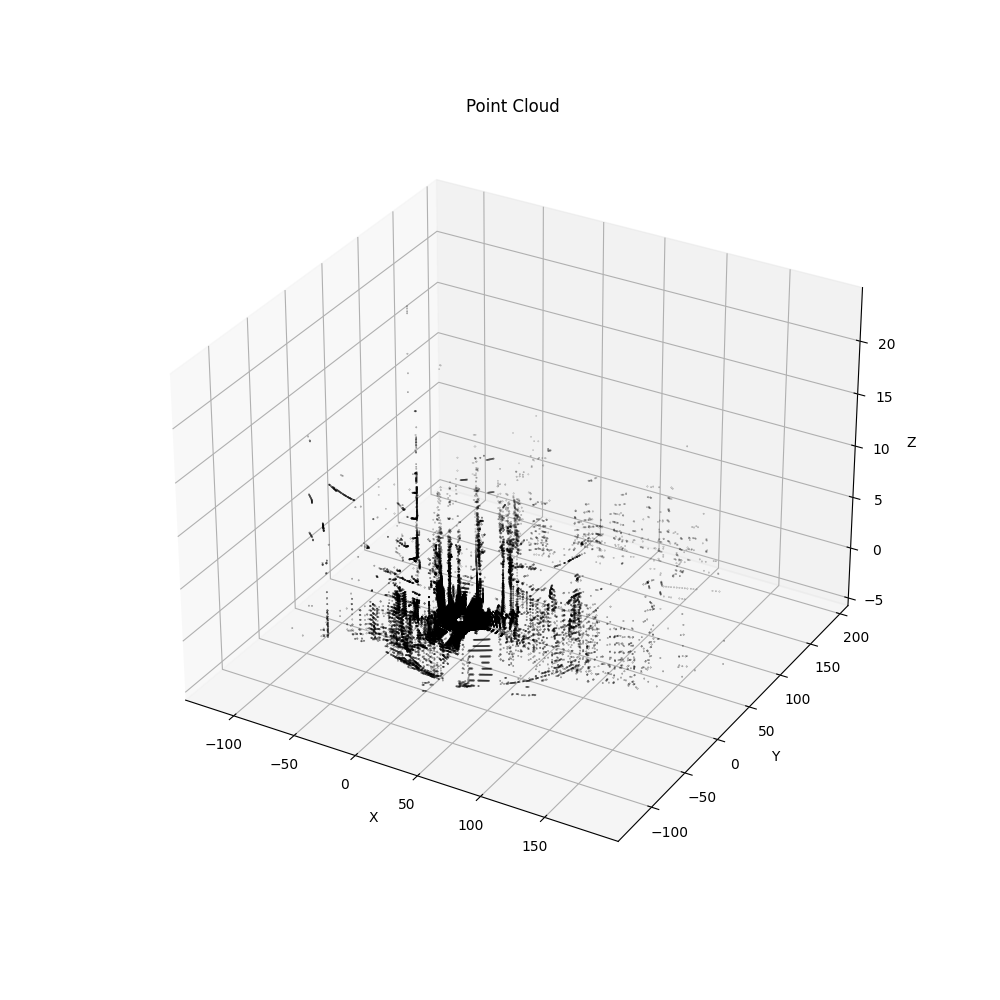

In [28]:
fbin = train_lidar_path + "data/000076/lidar_roof/1616343527200.bin"


point_cloud = np.fromfile(fbin, dtype=np.float32).reshape(-1, 4)
print(point_cloud)

# plot the point cloud in 3D
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))

ax.scatter3D(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=0.05, c='black')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud')
plt.show()

Car
[[-1.4664810e+00  8.9188538e+01  4.6170454e+00  1.1000000e-01]
 [-1.2718700e+00  7.7352669e+01  2.6353395e+00  9.9999998e-03]
 [ 4.2668800e+00  7.5725891e+01  2.1331437e+00  1.1000000e-01]
 ...
 [-1.4359695e-01  7.2035260e+00 -1.6701518e+00  3.9999999e-02]
 [-1.3412625e-01  6.7284298e+00 -1.6787925e+00  3.8999999e-01]
 [-1.4453445e-02  7.2505552e-01 -3.3776557e-01  0.0000000e+00]]


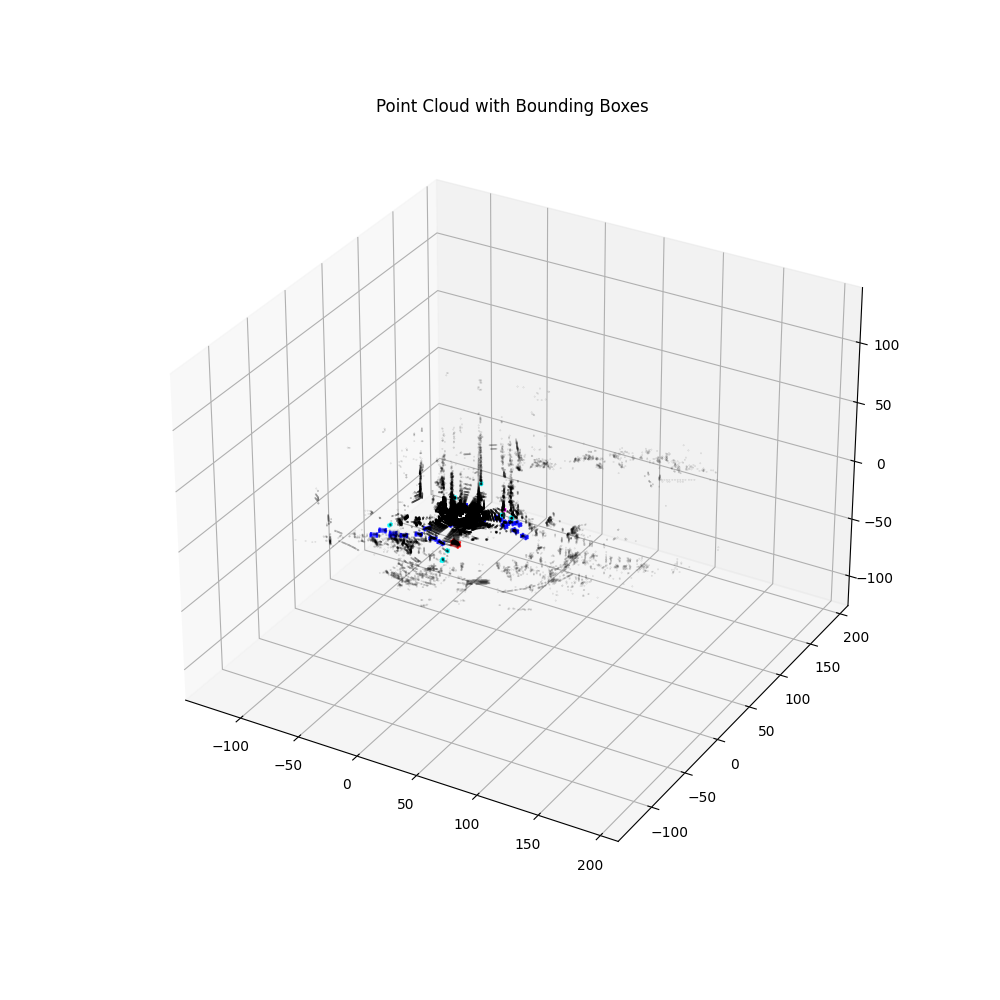

In [29]:
# Read labels from json
flabels = train_labels_path + "data/000076/000076.json"

with open(flabels) as f:
    labels = json.load(f)

annotations = labels["frames"][0]["annos"]
# print(annotations)

box_class = annotations["names"][0]
print(box_class)
box = annotations["boxes_3d"][0]

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))

for name, box in zip(annotations["names"], annotations["boxes_3d"]):
    # center_x, center_y, center_z, l, w, h, yaw

    # find the corners of the box
    center_x, center_y, center_z, l, w, h, yaw = box

    corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
    corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
    corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
    points = np.hstack((corners_x, corners_y, corners_z))

    # rotation matrix
    R = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                [np.sin(-yaw),  np.cos(-yaw), 0],
                [          0,            0, 1]])
    # rotate the box
    points = points @ R

    # offset the box with center position
    points[:, 0] += center_x
    points[:, 1] += center_y
    points[:, 2] += center_z

    # colors
    point_c = "black"
    line_c = class_colors[name]

    # plot the points
    # ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=10, c=point_c, alpha=0.5)

    # plot 12 lines of bounding box
    for i in range(4):
        ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=0.5)
    for i in range(4):
        ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=0.5)
    for i in range(4):
        ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=0.5)

fbin = train_lidar_path + "data/000076/lidar_roof/1616343527200.bin"

point_cloud = np.fromfile(fbin, dtype=np.float32).reshape(-1, 4)
print(point_cloud)

# plot the point cloud in 3D
ax.scatter3D(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]

, s=0.05, c='black', alpha=0.2)

ax.set_aspect('equal', adjustable='box')

ax.set_label('X')
ax.set_label('Y')
ax.set_label('Z')

ax.set_title('Point Cloud with Bounding Boxes')

plt.show()

In [61]:
#make the dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


class ObjectDetectionDataset(Dataset):
    def __init__(self, point_cloud_data, annotations):
        self.point_cloud_data = point_cloud_data
        self.annotations = annotations
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #return data point cloud scene and targets (bounding boxes)
        return self.point_cloud_data[idx].type(torch.tensor), self.annotations[idx].type(torch.tensor)



targets = []
inputs = []

for name, box in zip(annotations["names"], annotations["boxes_3d"]):
    targets.append(torch.tensor(np.append(classes[name], box)))

#todo: make more data points
inputs = torch.tensor(point_cloud[:, 0:3])
print(inputs.shape)

dataset = ObjectDetectionDataset(inputs, targets)

dataset[0][0].shape

torch.Size([62998, 3])


torch.Size([3])